In [31]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import keras.backend as K
import json
import requests

import matplotlib.pyplot as plt
from sklearn import preprocessing

from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model

tf.random.set_seed(1234)

In [32]:
# Gather Dataset

ent_ext_df = pd.read_csv("https://raw.githubusercontent.com/kkdelux/COMP542StockGAN/main/COMP542StockGANDataset.csv")

delayed_ent_ext_df = ent_ext_df[ent_ext_df["start_index"] >= 10]

delayed_ent_ext_df[delayed_ent_ext_df["ticker"] == "GE"]

,ticker,entry,exit,profit,days_to_wait,start_index
6,GE,8.64000,9.14303,0.058221,1,10
7,GE,8.79367,9.22800,0.049391,1,11
8,GE,8.29100,8.87600,0.070558,1,14
9,GE,8.12400,9.17300,0.129124,1,15
10,GE,8.77500,9.08200,0.034986,1,17
...,...,...,...,...,...,...
7747,GE,8.78500,10.82700,0.232442,31,469
7748,GE,8.85900,10.76000,0.214584,31,470
7749,GE,8.69000,10.74700,0.236709,31,471
7750,GE,8.88500,10.81550,0.217276,31,472


In [33]:
# Gather Stock Bar Data

res = requests.get("https://raw.githubusercontent.com/kkdelux/COMP542StockGAN/main/stock_bars.json")

bars = res.json()

SYMBOLS = list(bars.keys())

pd.DataFrame(bars["GE"]).head(10)

,t,o,h,l,c,v
0,1546405200,7.460,8.18,7.410,8.0250,118691164
1,1546491600,8.020,8.20,7.500,8.0650,104414212
2,1546578000,8.190,8.26,7.980,8.2100,102709035
3,1546837200,8.545,8.79,7.390,8.7500,162690859
4,1546923600,8.910,9.04,8.515,8.5650,134300920
5,1547010000,8.520,8.76,8.180,8.5300,98231155
6,1547096400,8.500,8.94,8.485,8.9201,96939524
7,1547182800,8.870,8.95,8.720,8.9300,72956922
8,1547442000,8.810,9.00,8.760,8.8800,71223338
9,1547528400,8.910,8.93,8.700,8.7101,76375904


In [34]:
# Get bars for GE

ge_bars = []

for bar in bars["GE"]:
  ge_bars.append([bar["o"], bar["h"], bar["l"], bar["c"], bar["v"]])

ge_bars = np.array(ge_bars)
ge_bars.shape, ge_bars

((505, 5),
 array([[7.46000000e+00, 8.18000000e+00, 7.41000000e+00, 8.02500000e+00,
         1.18691164e+08],
        [8.02000000e+00, 8.20000000e+00, 7.50000000e+00, 8.06500000e+00,
         1.04414212e+08],
        [8.19000000e+00, 8.26000000e+00, 7.98000000e+00, 8.21000000e+00,
         1.02709035e+08],
        ...,
        [1.06600000e+01, 1.07700000e+01, 1.05400000e+01, 1.05600000e+01,
         4.89132090e+07],
        [1.05800000e+01, 1.08450000e+01, 1.05500000e+01, 1.07150000e+01,
         4.79385530e+07],
        [1.06500000e+01, 1.08300000e+01, 1.05800000e+01, 1.07900000e+01,
         4.28057330e+07]]))

In [35]:
# Set Model Hyper Parameters
horizons = [5,10,20]

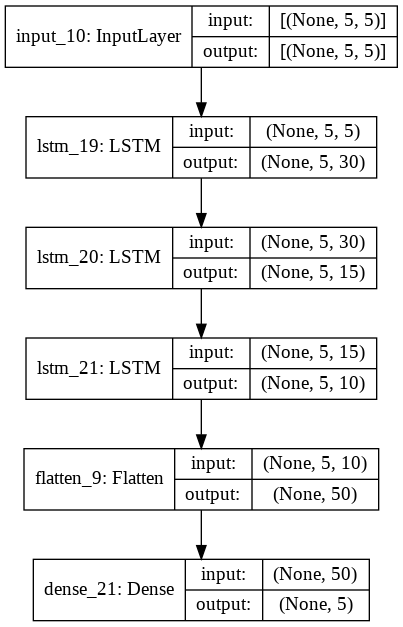

In [36]:
# Build Generator

def build_generator(horiz):
  # Bars Input
  bars_input = Input(shape=(horiz, 5,))

  # Stacked-LSTM Layers
  gen_model = LSTM(30, input_shape=(horiz, 5,), return_sequences=True)(bars_input)
  gen_model = LSTM(15, return_sequences=True)(gen_model)
  gen_model = LSTM(10, return_sequences=True)(gen_model)
  gen_model = Flatten()(gen_model)

  # output layer
  gen_model = Dense(5, activation="relu")(gen_model)

  return Model(inputs=bars_input, outputs=gen_model)

plot_model(build_generator(5), to_file="generator_5.png", show_shapes=True)

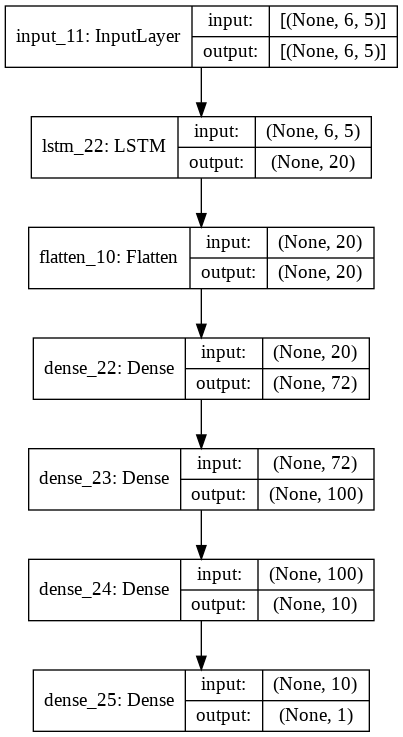

In [37]:
# Build Discriminator

def build_discriminator(horiz):
  # Input Layers
  bars_input = Input(shape=(horiz+1, 5,))

  # Hidden Layers
  disc_model = LSTM(20, input_shape=(horiz+1, 5,))(bars_input)
  disc_model = Flatten()(disc_model)
  disc_model = Dense(72, activation="sigmoid")(disc_model)
  disc_model = Dense(100, activation="sigmoid")(disc_model)
  disc_model = Dense(10, activation="sigmoid")(disc_model)

  # Output Layer
  disc_model = Dense(1, activation="sigmoid")(disc_model)

  return Model(inputs=bars_input,outputs=disc_model)

plot_model(build_discriminator(5), to_file="discriminator_5.png", show_shapes=True)

In [38]:
# Prepare data for each horizon

horizoned_bars = { str(k): [] for k in horizons }

for k in horizons:
  for i in range(k, len(ge_bars)-1):
    X = ge_bars[i-k:i].transpose()
    y = ge_bars[i]
    horizoned_bars[str(k)].append([X, y])

ge_bars[-3], horizoned_bars["5"][-1]

(array([1.0660000e+01, 1.0770000e+01, 1.0540000e+01, 1.0560000e+01,
        4.8913209e+07]),
 [array([[1.0710000e+01, 1.0680000e+01, 1.0850000e+01, 1.0700000e+01,
          1.0660000e+01],
         [1.0760000e+01, 1.0980000e+01, 1.0850000e+01, 1.0780000e+01,
          1.0770000e+01],
         [1.0490000e+01, 1.0620000e+01, 1.0620000e+01, 1.0580000e+01,
          1.0540000e+01],
         [1.0610000e+01, 1.0860000e+01, 1.0650000e+01, 1.0640000e+01,
          1.0560000e+01],
         [7.3704092e+07, 5.3927100e+07, 2.7826042e+07, 5.0165034e+07,
          4.8913209e+07]]),
  array([1.0580000e+01, 1.0845000e+01, 1.0550000e+01, 1.0715000e+01,
         4.7938553e+07])])

In [39]:
# Normalize the data

normalized_horizoned_bars = { str(k): [] for k in horizons }

for key in horizoned_bars.keys():
  for row in horizoned_bars[key]:
    meta = {'mean': {}, 'std': {}}
    X = row[0]
    y = list(row[1])
    o, h, l, c, v = X

    meta["mean"]["o"] = o.mean()
    meta["std"]["o"] = o.std()
    meta["mean"]["h"] = h.mean()
    meta["std"]["h"] = h.std()
    meta["mean"]["l"] = l.mean()
    meta["std"]["l"] = l.std()
    meta["mean"]["c"] = c.mean()
    meta["std"]["c"] = c.std()
    meta["mean"]["v"] = v.mean()
    meta["std"]["v"] = v.std()

    o = (o - meta["mean"]["o"]) / meta["std"]["o"]
    h = (h - meta["mean"]["h"]) / meta["std"]["h"]
    l = (l - meta["mean"]["l"]) / meta["std"]["l"]
    c = (c - meta["mean"]["c"]) / meta["std"]["c"]
    v = (v - meta["mean"]["v"]) / meta["std"]["v"]

    y[0] = (y[0] - meta["mean"]["o"]) / meta["std"]["o"]
    y[1] = (y[1] - meta["mean"]["h"]) / meta["std"]["h"]
    y[2] = (y[2] - meta["mean"]["l"]) / meta["std"]["l"]
    y[3] = (y[3] - meta["mean"]["c"]) / meta["std"]["c"]
    y[4] = (y[4] - meta["mean"]["v"]) / meta["std"]["v"]

    normalized_horizoned_bars[key].append([np.array([o,h,l,c,v]).transpose(), np.array(y), meta])

horizoned_bars["5"][-1], normalized_horizoned_bars["5"][-1]

([array([[1.0710000e+01, 1.0680000e+01, 1.0850000e+01, 1.0700000e+01,
          1.0660000e+01],
         [1.0760000e+01, 1.0980000e+01, 1.0850000e+01, 1.0780000e+01,
          1.0770000e+01],
         [1.0490000e+01, 1.0620000e+01, 1.0620000e+01, 1.0580000e+01,
          1.0540000e+01],
         [1.0610000e+01, 1.0860000e+01, 1.0650000e+01, 1.0640000e+01,
          1.0560000e+01],
         [7.3704092e+07, 5.3927100e+07, 2.7826042e+07, 5.0165034e+07,
          4.8913209e+07]]),
  array([1.0580000e+01, 1.0845000e+01, 1.0550000e+01, 1.0715000e+01,
         4.7938553e+07])],
 [array([[-0.14874103, -0.8260802 , -1.60643866, -0.52489066,  1.56122958],
         [-0.59496412,  1.84653222,  1.00402416,  1.90515869,  0.206822  ],
         [ 1.93363338,  0.26726124,  1.00402416, -0.13608276, -1.58068293],
         [-0.29748206, -0.58311544,  0.20080483, -0.23328474, -0.05081934],
         [-0.89244618, -0.70459782, -0.6024145 , -1.01090053, -0.13654932]]),
  array([-2.08237441,  0.20652005, -0.40

In [40]:
# Split the data

training_data = { str(k): [] for k in horizons }
testing_data = { str(k): [] for k in horizons }

for key in normalized_horizoned_bars.keys():
  for idx, row in enumerate(normalized_horizoned_bars[key]):
    if idx > int(len(normalized_horizoned_bars[key]) * 0.80):
      testing_data[key].append(row)
    else:
      training_data[key].append(row)

len(normalized_horizoned_bars["5"]), len(training_data["5"]), len(testing_data["5"])

(499, 400, 99)

In [41]:
# Generator Loss
def generator_loss(x, y, fake_output):
    a1=0.05
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*tf.cast(g_loss, tf.float64), g_mse

In [42]:
# -- Optimizers
d_optimizer = Adam(learning_rate=0.0002)
g_optimizer = Adam(learning_rate=0.0002)

# -- Loss
loss_fn = BinaryCrossentropy(from_logits=True)

# -- Training Step
@tf.function
def train_step(generator, discriminator, real_bars, real_targets):

  # Generate data based on the fake bars
  generated = generator(real_bars)

  generated = tf.concat([real_bars, tf.expand_dims(generated, 1)], axis=1)
  disc_bars = tf.concat([real_bars, tf.expand_dims(real_targets, 1)], axis=1)

  # combined data
  combined_bars = tf.concat([generated, tf.cast(disc_bars, tf.float32)], axis=0)

  # Label based on batch size
  labels = tf.concat(
      [tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0
  )
  # Add random noise to the labels
  labels += 0.05 * tf.random.uniform(labels.shape)

  # Generate misleading labels
  misleading_labels = tf.zeros((BATCH_SIZE, 1))

  # Train the Discriminator
  with tf.GradientTape() as tape:
    predictions = discriminator(combined_bars, training=True)
    d_loss = loss_fn(labels, predictions)
  grads = tape.gradient(d_loss, discriminator.trainable_weights)
  d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

  # Train the Generator
  with tf.GradientTape() as tape:
    fake = generator(real_bars, training=True)
    generated = tf.concat([real_bars, tf.expand_dims(fake, 1)], axis=1)
    predictions = discriminator(generated)
    g_loss, g_mse = generator_loss(fake, real_targets, predictions)
  grads = tape.gradient(g_loss, generator.trainable_weights)
  g_optimizer.apply_gradients(zip(grads, generator.trainable_weights)) 

  return d_loss, g_loss, g_mse

In [43]:
# Train Models

BATCH_SIZE = 20
EPOCHS = 150

generators = { str(k):None for k in horizons }
discriminators = { str(k):None for k in horizons }

steps = { str(k):[] for k in horizons }
generator_losses = { str(k):[] for k in horizons }
generator_mses = { str(k):[] for k in horizons }
discriminator_losses = { str(k):[] for k in horizons }

for k in horizons:
  key = str(k)

  generator = build_generator(k)
  discriminator = build_discriminator(k)

  for epoch in range(EPOCHS):
    print("\nStart Epoch", epoch, "for Horizon", key)

    for step in range(BATCH_SIZE, len(training_data[key]), BATCH_SIZE):
      real_data = training_data[key][step-BATCH_SIZE:step]

      real_bars = np.array([ row[0] for row in real_data])

      real_targets = np.array([ row[1] for row in real_data])

      # print(step, len(real_data), len(real_targets), real_bars)

      # Train Discriminator and Generator on one batch of real data
      d_loss, g_loss, g_mse = train_step(generator, discriminator, real_bars, real_targets)

      steps[key].append(step)
      discriminator_losses[key].append(d_loss)
      generator_losses[key].append(g_loss.numpy().mean())
      generator_mses[key].append(g_mse.numpy().mean())

      if step % 100 == 0:
        # Print Metrics
        print("\tLoss at step %d: Discriminator %.2f | Generator %.2f" % (step, d_loss, g_loss[-1]))

  generators[key] = generator
  discriminators[key] = discriminator


Start Epoch 0 for Horizon 5
	Loss at step 100: Discriminator 0.74 | Generator 0.99
	Loss at step 200: Discriminator 0.73 | Generator 1.02
	Loss at step 300: Discriminator 0.72 | Generator 0.96

Start Epoch 1 for Horizon 5
	Loss at step 100: Discriminator 0.71 | Generator 0.85
	Loss at step 200: Discriminator 0.70 | Generator 0.89
	Loss at step 300: Discriminator 0.70 | Generator 0.83

Start Epoch 2 for Horizon 5
	Loss at step 100: Discriminator 0.69 | Generator 0.75
	Loss at step 200: Discriminator 0.69 | Generator 0.80
	Loss at step 300: Discriminator 0.69 | Generator 0.76

Start Epoch 3 for Horizon 5
	Loss at step 100: Discriminator 0.69 | Generator 0.70
	Loss at step 200: Discriminator 0.69 | Generator 0.75
	Loss at step 300: Discriminator 0.69 | Generator 0.73

Start Epoch 4 for Horizon 5
	Loss at step 100: Discriminator 0.69 | Generator 0.68
	Loss at step 200: Discriminator 0.69 | Generator 0.74
	Loss at step 300: Discriminator 0.69 | Generator 0.72

Start Epoch 5 for Horizon 5
	

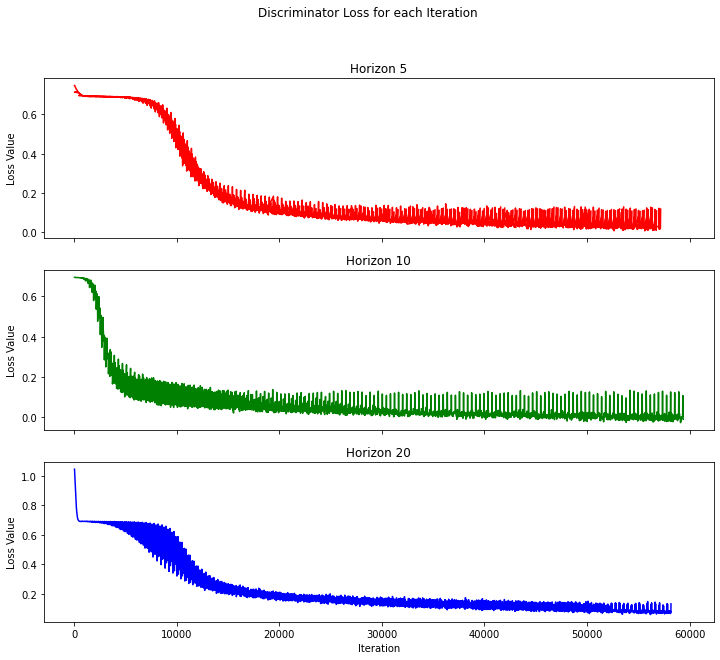

In [44]:
# Check Discriminator Losses

fig, ax = plt.subplots(3, 1, sharex=True)

fig.set_size_inches(12,10)

colors = ["r","g","b"]

for i in range(len(horizons)):
  key = str(horizons[i])
  steps[key] = np.array(steps[key])

  X_buff = np.array([])
  y_buff = np.array([])

  for e in range(EPOCHS):
    breakpoint = int(len(training_data[key])/BATCH_SIZE)

    X = steps[key][breakpoint*e: breakpoint*(e+1)] + (len(training_data[key]) * e)
    y = discriminator_losses[key][breakpoint*e: breakpoint*(e+1)]

    X_buff = np.append(X_buff, X, 0)
    y_buff = np.append(y_buff, y, 0)

  ax[i].plot(X_buff, y_buff, label="Horizon " + key, c=colors[i])
  ax[i].set_ylabel("Loss Value")
  ax[i].set_title("Horizon " + key)

fig.suptitle("Discriminator Loss for each Iteration")
ax[2].set_xlabel("Iteration")

# fig.legend()
fig.show()

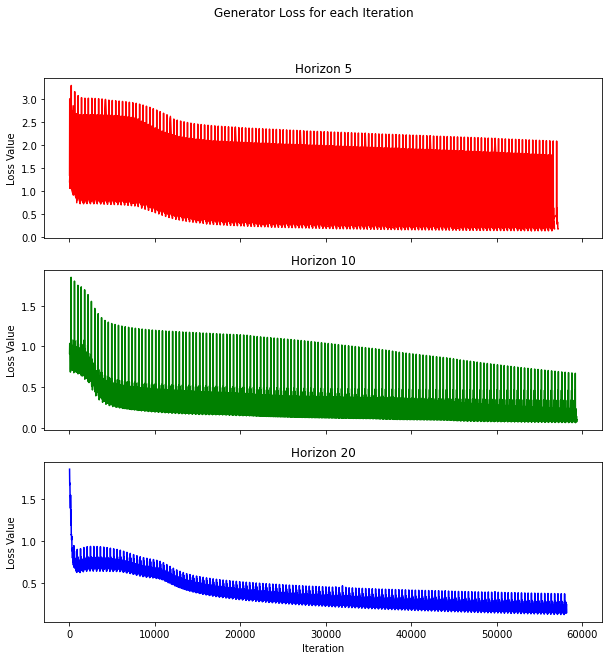

In [45]:
# Check Generator Losses

fig, ax = plt.subplots(3, 1, sharex=True)

fig.set_size_inches(10,10)

colors = ["r","g","b"]

for i in range(len(horizons)):
  key = str(horizons[i])
  steps[key] = np.array(steps[key])

  X_buff = np.array([])
  y_buff = np.array([])

  for e in range(EPOCHS):
    breakpoint = int(len(training_data[key])/BATCH_SIZE)

    X = steps[key][breakpoint*e: breakpoint*(e+1)] + (len(training_data[key]) * e)
    y = generator_losses[key][breakpoint*e: breakpoint*(e+1)]

    X_buff = np.append(X_buff, X, 0)
    y_buff = np.append(y_buff, y, 0)

  ax[i].plot(X_buff, y_buff, label="Horizion " + key, c=colors[i])
  ax[i].set_ylabel("Loss Value")
  ax[i].set_title("Horizon " + key)

fig.suptitle("Generator Loss for each Iteration")
ax[2].set_xlabel("Iteration")

# fig.legend()
fig.show()

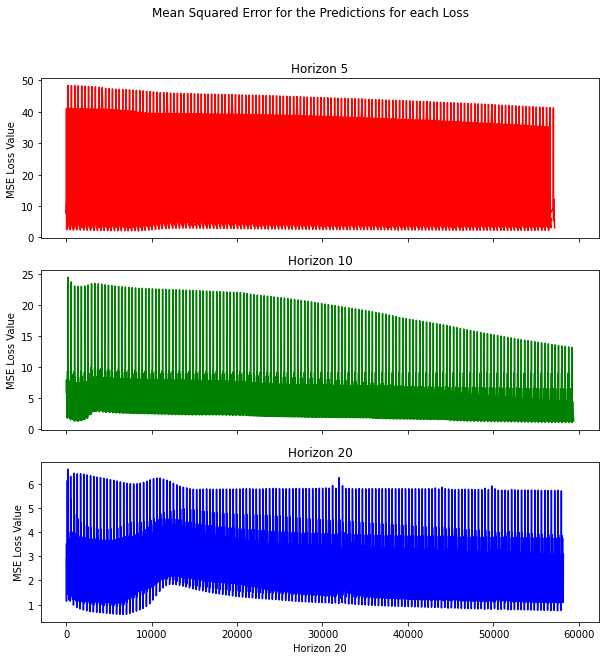

In [46]:
# Check Generator MSE

fig, ax = plt.subplots(3, 1, sharex=True)

fig.set_size_inches(10,10)

colors = ["r","g","b"]

for i in range(len(horizons)):
  key = str(horizons[i])
  steps[key] = np.array(steps[key])

  X_buff = np.array([])
  y_buff = np.array([])

  for e in range(EPOCHS):
    breakpoint = int(len(training_data[key])/BATCH_SIZE)

    X = steps[key][breakpoint*e: breakpoint*(e+1)] + (len(training_data[key]) * e)
    y = generator_mses[key][breakpoint*e: breakpoint*(e+1)]

    X_buff = np.append(X_buff, X, 0)
    y_buff = np.append(y_buff, y, 0)

  ax[i].plot(X_buff, y_buff, label="Horizion " + key, c=colors[i])
  ax[i].set_ylabel("MSE Loss Value")
  ax[i].set_title("Horizon " + key)

fig.suptitle("Mean Squared Error for the Predictions for each Loss")
ax[2].set_xlabel("Horizon " + key)

# fig.legend()
fig.show()

In [47]:
# Test the models

predictions = { str(k): [] for k in horizons }
actuals = { str(k): [] for k in horizons }

for k in horizons:
  key = str(k)

  for row in testing_data[key]:
    X, y, meta = row

    pred = generators[key](tf.expand_dims(X, 0))

    close_pred = pred[0][3] * meta["std"]["c"] + meta["mean"]["c"]
    close_actu = y[3] * meta["std"]["c"] + meta["mean"]["c"]

    predictions[key].append(close_pred.numpy())
    actuals[key].append(close_actu)

In [48]:
# RMSE

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

tf.Tensor(0.24506544789452997, shape=(), dtype=float64)


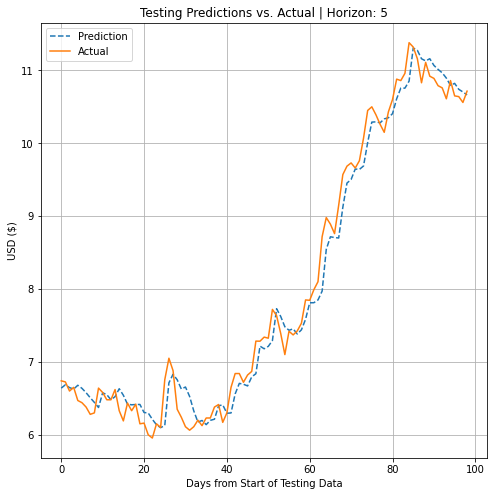

In [49]:
X = range(len(predictions["5"]))

plt.figure().set_size_inches(8,8)

plt.plot(X, predictions["5"], label="Prediction", linestyle="dashed")
plt.plot(X, actuals["5"], label="Actual")
plt.title("Testing Predictions vs. Actual | Horizon: 5")
plt.grid()
plt.legend()

plt.ylabel("USD ($)")
plt.xlabel("Days from Start of Testing Data")

print(root_mean_squared_error(np.array(actuals["5"]), np.array(predictions["5"])))

plt.show()

tf.Tensor(0.33923840764532875, shape=(), dtype=float64)


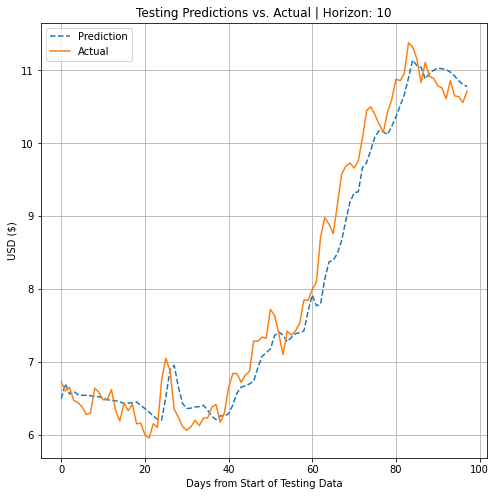

In [50]:
X = range(len(predictions["10"]))

plt.figure().set_size_inches(8,8)

plt.plot(X, predictions["10"], label="Prediction", linestyle="dashed")
plt.plot(X, actuals["10"], label="Actual")
plt.title("Testing Predictions vs. Actual | Horizon: 10")
plt.grid()
plt.legend()

plt.ylabel("USD ($)")
plt.xlabel("Days from Start of Testing Data")

print(root_mean_squared_error(np.array(actuals["10"]), np.array(predictions["10"])))

plt.show()

tf.Tensor(0.3092524173293352, shape=(), dtype=float64)


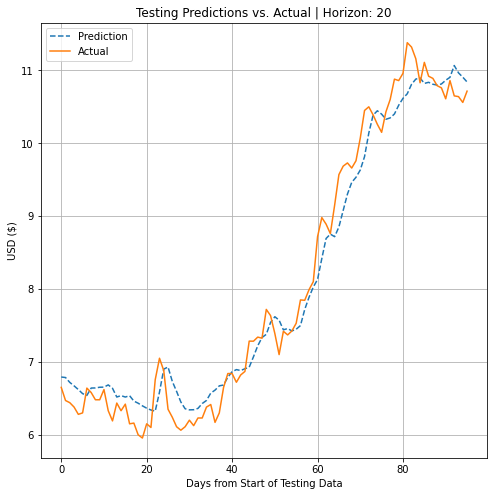

In [51]:
X = range(len(predictions["20"]))

plt.figure().set_size_inches(8,8)

plt.plot(X, predictions["20"], label="Prediction", linestyle="dashed")
plt.plot(X, actuals["20"], label="Actual")
plt.title("Testing Predictions vs. Actual | Horizon: 20")
plt.grid()
plt.legend()

plt.ylabel("USD ($)")
plt.xlabel("Days from Start of Testing Data")

print(root_mean_squared_error(np.array(actuals["20"]), np.array(predictions["20"])))

plt.show()

In [52]:
# Utility data structure for simulation

class CircularBarsBuffer:
  '''Circular Buffer for Holding the bars'''

  def __init__(self, horiz):
    self.size = horiz
    self.start = 0
    self.buff = []

  def initialize_buffer(self, bars):
    self.buff = list(bars)

  def first_add_bar(self, bar):
    self.buff.append(bar)

  def rotate_add_bar(self, bar):
    self.buff[(self.start+self.size)%self.size] = bar
    self.start += 1

  def to_numpy(self):
    to_ret = []
    for i in range(self.size):
      to_ret.append(self.buff[((self.start+i)%self.size)])

    return np.array(to_ret)

In [53]:
# Test CircularBarBuffer

initial_bars = testing_data["5"][0][0]

BarsBuffer = CircularBarsBuffer(5)
BarsBuffer.initialize_buffer(list(initial_bars))

# -- Get guess
guess = generators["5"](tf.expand_dims(initial_bars, 0)).numpy()[0]

# -- Insert guess into buffer
BarsBuffer.rotate_add_bar(guess)
bars = BarsBuffer.to_numpy()

# -- Get second guess
guess = generators["5"](tf.expand_dims(bars,0))

(tf.expand_dims(bars,0)), guess

(<tf.Tensor: shape=(1, 5, 5), dtype=float64, numpy=
 array([[[-0.80415345, -0.22542307, -0.89642146,  0.00587788,
           1.62878894],
         [ 0.56461838, -0.10018803,  0.49801192, -0.31740553,
          -0.93753529],
         [ 0.22242542,  0.15028204,  0.19920477,  0.00587788,
          -0.03905479],
         [ 1.42010076,  1.65310248,  1.49403576,  1.71046312,
           0.46569197],
         [ 3.17699528,  2.90017819,  0.        ,  1.47282064,
           0.68837094]]])>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[0.61457956, 0.3983739 , 0.        , 0.        , 0.00912261]],
       dtype=float32)>)

In [54]:
# Setup Simulation

def simulate(model, horiz, lookahead):
  START_CASH = tf.Variable(10000.)
  curr_cash = START_CASH

  trades_count = 0
  trades_arr = []
  trades_res = []

  index = 0

  while index < len(testing_data[str(horiz)]):
    row = testing_data[str(horiz)][index]

    entry = 10000
    exit = 0

    X,y,meta = row

    Buffer = CircularBarsBuffer(horiz)
    Buffer.initialize_buffer(list(X))

    guess = model(tf.expand_dims(Buffer.to_numpy(), 0))[0]

    # convert the close based on the meta
    close_pred = guess[3]*meta["std"]["c"] + meta["mean"]["c"]

    # assign close of first predicted day to be the entry price
    entry = close_pred

    # Update buffer
    Buffer.rotate_add_bar(guess)

    # do lookahead
    for _ in range(lookahead):
      guess = model(tf.expand_dims(Buffer.to_numpy(), 0))[0]

      lookahead_close_pred = guess[3]*meta["std"]["c"] + meta["mean"]["c"]

      if lookahead_close_pred > exit:
        exit = lookahead_close_pred

      # Update buffer
      Buffer.rotate_add_bar(guess)

    target_high = y[1]*meta["std"]["h"] + meta["mean"]["h"]
    target_low = y[2]*meta["std"]["l"] + meta["mean"]["l"]

    # if entry < exit: print(entry.numpy(), exit.numpy(), target_high, target_low)

    # check if trade is possible
    if exit > entry and entry < target_high and entry > target_low:
      # make trade
      amount = int(curr_cash / entry)
      total = amount * entry

      curr_cash = curr_cash - total

      trades_arr.append([total.numpy(), amount, entry.numpy(), index])
      trades_count += 1

      closed = False

      # close out trade
      for i in range(1, min(lookahead, len(testing_data[str(horiz)]) - index)):
        target_row = testing_data[str(horiz)][index+i]
        t_X, t_y, t_meta = target_row
        target_close = t_y[3] * t_meta["std"]["c"] + t_meta["mean"]["c"]

        # trade is closable
        if target_close > exit:
          liquidate = exit * amount - 10

          # print("Closed | Current Cash:", curr_cash.numpy(), "+", liquidate.numpy(), "=", (curr_cash+liquidate).numpy())
          curr_cash = curr_cash + liquidate
          # print("Cash = ", curr_cash.numpy())

          percent = (exit - entry) / entry
          profit = liquidate - total

          trades_res.append([percent.numpy(), profit.numpy(), index+i, "Closed"])

          index = index + i
          closed = True
          break
      
      if not closed:
        # Trade does not close within lookahead
        index = index + min(lookahead, len(testing_data[str(horiz)])- 1 - index)

        target_row = testing_data[str(horiz)][index]
        t_X, t_y, t_meta = target_row
        target_close = t_y[3] * t_meta["std"]["c"] + t_meta["mean"]["c"]

        liquidate = target_close * amount - 10
        # print("Fell | Current Cash:", curr_cash.numpy(), "+", liquidate, "=", (curr_cash+liquidate).numpy())
        curr_cash = curr_cash + liquidate
        # print("Cash = ", curr_cash.numpy())

        percent = (exit - entry) / entry
        profit = liquidate - total

        trades_res.append([percent.numpy(), profit.numpy(), index, "Fell Through"])
        # end if trade

    index += 1

  return [curr_cash.numpy(), trades_count, trades_arr, trades_res]


In [55]:
# Test simulation
simulate(generators["10"], 10, 5)

[9916.838,
 10,
 [[9998.599, 1532, 6.5265, 8],
  [9686.996, 1507, 6.428, 15],
  [9032.233, 1454, 6.21199, 23],
  [9355.595, 1496, 6.25374, 36],
  [9501.461, 1518, 6.2591968, 38],
  [9545.035, 1425, 6.6982703, 45],
  [9721.134, 1316, 7.38688, 56],
  [9764.153, 1269, 7.694368, 59],
  [10358.08, 939, 11.03097, 90],
  [9981.3545, 926, 10.779, 97]],
 [[0.03635031, -311.03906, 13, 'Fell Through'],
  [0.0020189174, -654.9961, 20, 'Fell Through'],
  [0.03680825, 322.46094, 24, 'Closed'],
  [0.016966319, 148.73047, 37, 'Closed'],
  [0.0059207766, 46.25586, 39, 'Closed'],
  [0.019228833, 173.54004, 46, 'Closed'],
  [0.005596392, 44.40332, 57, 'Closed'],
  [0.061845377, 593.8672, 62, 'Closed'],
  [0.015623755, -377.12012, 95, 'Fell Through'],
  [0.030715851, -69.26465, 97, 'Fell Through']]]

In [62]:
# Collect data for simulaitons
total_by_lookahead = { str(k): [] for k in horizons }

for k in horizons:
  print("Starting Simulations for horizon", k)
  for look in range(1,16):
    total = simulate(generators[str(k)], k, look)[0]
    print("\tLookahead: ", look, "Total: ", total)

    total_by_lookahead[str(k)].append([total, look])

Starting Simulations for horizon 5
	Lookahead:  1 Total:  10294.687
	Lookahead:  2 Total:  9182.946
	Lookahead:  3 Total:  9583.884
	Lookahead:  4 Total:  10006.739
	Lookahead:  5 Total:  9469.488
	Lookahead:  6 Total:  9830.449
	Lookahead:  7 Total:  9683.444
	Lookahead:  8 Total:  9350.227
	Lookahead:  9 Total:  9502.828
	Lookahead:  10 Total:  9296.936
	Lookahead:  11 Total:  10121.52
	Lookahead:  12 Total:  9896.087
	Lookahead:  13 Total:  10271.495
	Lookahead:  15 Total:  10404.49
Starting Simulations for horizon 10
	Lookahead:  1 Total:  11158.344
	Lookahead:  2 Total:  10288.023
	Lookahead:  3 Total:  10652.386
	Lookahead:  4 Total:  10577.423
	Lookahead:  5 Total:  9916.838
	Lookahead:  6 Total:  10013.237
	Lookahead:  7 Total:  11041.151
	Lookahead:  8 Total:  10348.924
	Lookahead:  9 Total:  10832.382
	Lookahead:  10 Total:  10886.389
	Lookahead:  11 Total:  10539.412
	Lookahead:  12 Total:  10557.361
	Lookahead:  13 Total:  10906.068
	Lookahead:  14 Total:  10807.8
	Lookahea

In [57]:
# LSTM for comparison

lstm = build_generator(10)

opt = Adam(learning_rate=0.0004)
lstm_loss = tf.keras.losses.mean_squared_error

for epoch in range(EPOCHS):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step in range(BATCH_SIZE, len(training_data[key]), BATCH_SIZE):
      real_data = training_data["10"][step-BATCH_SIZE:step]
      real_bars = np.array([ row[0] for row in real_data])
      real_targets = np.array([ row[1] for row in real_data])

      # Open a GradientTape to record the operations run
      # during the forward pass, which enables auto-differentiation.
      with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        logits = lstm(real_bars, training=True)  # Logits for this minibatch

        # Compute the loss value for this minibatch.
        loss_value = lstm_loss(real_targets, logits)

      # Use the gradient tape to automatically retrieve
      # the gradients of the trainable variables with respect to the loss.
      grads = tape.gradient(loss_value, lstm.trainable_weights)

      # Run one step of gradient descent by updating
      # the value of the variables to minimize the loss.
      opt.apply_gradients(zip(grads, lstm.trainable_weights))

      # Log every 200 batches.
      if step % 200 == 0:
       print(
         "Training loss (for one batch) at step %d: %.4f"
         % (step, float(loss_value.numpy().mean()))
       )


Start of epoch 0
Training loss (for one batch) at step 200: 24.6793

Start of epoch 1
Training loss (for one batch) at step 200: 24.5115

Start of epoch 2
Training loss (for one batch) at step 200: 24.2534

Start of epoch 3
Training loss (for one batch) at step 200: 23.8645

Start of epoch 4
Training loss (for one batch) at step 200: 23.4335

Start of epoch 5
Training loss (for one batch) at step 200: 23.1784

Start of epoch 6
Training loss (for one batch) at step 200: 23.0955

Start of epoch 7
Training loss (for one batch) at step 200: 23.0593

Start of epoch 8
Training loss (for one batch) at step 200: 23.0212

Start of epoch 9
Training loss (for one batch) at step 200: 22.9859

Start of epoch 10
Training loss (for one batch) at step 200: 22.9484

Start of epoch 11
Training loss (for one batch) at step 200: 22.9071

Start of epoch 12
Training loss (for one batch) at step 200: 22.8688

Start of epoch 13
Training loss (for one batch) at step 200: 22.8260

Start of epoch 14
Training lo

tf.Tensor(0.25838498580960184, shape=(), dtype=float64)


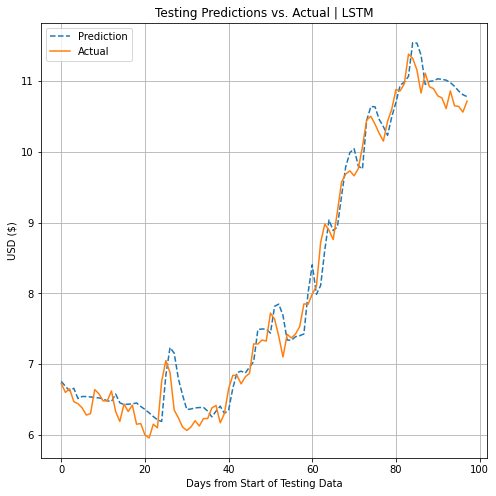

In [58]:
# Compare LSTM

predictions["lstm"] = []
actuals["lstm"] = []

key = "10"

for row in testing_data[key]:
  X, y, meta = row

  pred = lstm(tf.expand_dims(X, 0))

  close_pred = pred[0][3] * meta["std"]["c"] + meta["mean"]["c"]
  close_actu = y[3] * meta["std"]["c"] + meta["mean"]["c"]

  predictions["lstm"].append(close_pred.numpy())
  actuals["lstm"].append(close_actu)

X = range(len(predictions["lstm"]))

plt.figure().set_size_inches(8,8)

plt.plot(X, predictions["lstm"], label="Prediction", linestyle="dashed")
plt.plot(X, actuals["lstm"], label="Actual")
plt.title("Testing Predictions vs. Actual | LSTM")
plt.grid()
plt.legend()

plt.ylabel("USD ($)")
plt.xlabel("Days from Start of Testing Data")

print(root_mean_squared_error(np.array(actuals["lstm"]), np.array(predictions["lstm"])))

plt.show()

In [61]:
# Simulate LSTM

total_by_lookahead["lstm"] = []

for k in [10]:
  print("Starting Simulations for LSTM")
  for look in range(1,11):
    total = simulate(lstm, k, look)[0]
    print("\tLookahead: ", look, "Total: ", total)

    total_by_lookahead["lstm"].append([total, look])


Starting Simulations for LSTM
	Lookahead:  1 Total:  9957.264
	Lookahead:  2 Total:  8949.813
	Lookahead:  3 Total:  9334.905
	Lookahead:  4 Total:  10455.698
	Lookahead:  5 Total:  10254.272
	Lookahead:  6 Total:  9701.894
	Lookahead:  7 Total:  11081.171
	Lookahead:  8 Total:  11438.629
	Lookahead:  9 Total:  11018.491
	Lookahead:  10 Total:  11560.609


tf.Tensor(15884.925, shape=(), dtype=float32)


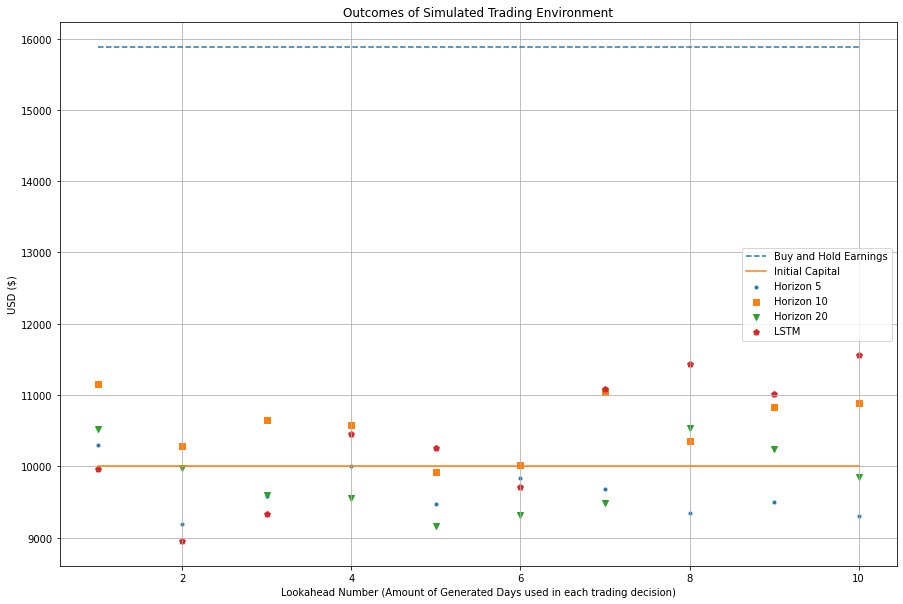

In [60]:
# Plot simulation marks

plt.figure().set_size_inches(15,10)

marks = [".", "s", "v", "p"]

total_by_lookahead["lstm"] = np.array(total_by_lookahead["lstm"])

i = 0
for key in list(total_by_lookahead.keys())[:-1]:
  total_by_lookahead[key] = np.array(total_by_lookahead[key])
  plt.scatter(total_by_lookahead[key][:,1], total_by_lookahead[key][:,0], label="Horizon " + key, marker=marks[i])
  i += 1

plt.scatter(total_by_lookahead["lstm"][:,1], total_by_lookahead["lstm"][:,0], label="LSTM", marker=marks[i])

# Calculate Buy and Hold Line
CASH = tf.Variable(10000.)

first_row = testing_data["5"][0]
last_row = testing_data["5"][-1]

f_X, f_y, f_meta = first_row
l_X, l_y, l_meta = last_row

entry = f_y[3] * f_meta["std"]["c"] + f_meta["mean"]["c"]
exit = l_y[3] * l_meta["std"]["c"] + l_meta["mean"]["c"]

amount = int(CASH / entry)
total = entry * amount

CASH = CASH - total

liquidate = exit * amount - 10
CASH = CASH + liquidate

plt.plot([1,10], [CASH.numpy(), CASH.numpy()], label="Buy and Hold Earnings", linestyle='dashed')
plt.plot([1,10], [10000, 10000], label="Initial Capital")

plt.title("Outcomes of Simulated Trading Environment")
plt.ylabel("USD ($)")
plt.xlabel("Lookahead Number (Amount of Generated Days used in each trading decision)")

print(CASH)

plt.legend()
plt.grid()
plt.gray()
plt.show()